In [2]:
import pandas as pd
import re
import os
import spacy
from scipy import constants
from nltk.tokenize import word_tokenize
from nltk.translate import AlignedSent
from nltk.translate import IBMModel1
from tqdm import tqdm
from spacy.matcher import PhraseMatcher
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import textwrap
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import openai
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, pipeline, AutoModelForTokenClassification
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler, Dataset
from gensim.utils import simple_preprocess
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report

In [3]:
data = pd.read_excel("./data/data.xlsx", engine="openpyxl")

In [4]:
data.columns

Index(['Unnamed: 0', 'label', 'text'], dtype='object')

In [5]:
data.drop(columns="Unnamed: 0",axis=1, inplace=True)

In [6]:
train_, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
train_data, val_data = train_test_split(train_, test_size=0.2, random_state=42, shuffle=True)

In [7]:
test_data.head(5)

,label,text
2010,__label__PA,tên nguyễn_việt_cường xin phản_ánh toàn công_c...
2083,__label__PA,hộ văn châu địa ấp xuân_hòa 1 xã vĩnh_đông huy...
2398,__label__PA,kính gửi cổng thông_tin điện_tử long_an vấn_đề...
2302,__label__KPA,gởi báo_cáo vi ohajm khá lâu trả_lời
792,__label__KPA,tên lê_thị_kim_ngân sinh 1995 hôm_nay xin gửi ...


In [8]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=258):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='__label__KPA':
            return 0
        else:
            return 1

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['text']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['label'])

        return text, label

In [9]:
class TextClassifier(nn.Module):
    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=n_classes)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        x = self.drop(logits)
        return x

In [10]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Clear GPU cache
torch.cuda.empty_cache()

model = TextClassifier(n_classes=2)
load_path = './results/5.pth'

# Load the state dictionary into the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model's state dict onto the specified device
model.load_state_dict(torch.load(load_path, map_location=device))
model.eval()

# Function to get predictions
# def predict(model, dataloader):
#     model.eval()
#     predictions = []

#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids = batch['input_ids']
#             attention_masks = batch['attention_masks']
#             outputs = model(input_ids, attention_masks)
#             preds = torch.argmax(outputs, dim=1)
#             predictions.extend(preds.cpu().numpy())

#     return predictions

global cm

def test(data_loader, n_classes):
    models = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load individual models trained on separate folds
    model = TextClassifier(n_classes=n_classes)  # Adjust as per your model architecture
    model.to(device)
    model.load_state_dict(torch.load(f'./results/5.pth', map_location=device))
    model.eval()
    models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    # Iterate over data loader
    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []

        # Predict with each model and aggregate predictions
        for model in models:
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)

        # Collect predictions and true values
        texts.extend(text)
        predicts.extend(pred.cpu())
        predict_probs.extend(total_outs.mean(0).cpu())
        real_values.extend(targets.cpu())
    
    # Convert lists to tensors
    predicts = torch.stack(predicts)
    predict_probs = torch.stack(predict_probs)
    real_values = torch.stack(real_values)

    # Calculate metrics
    accuracy = accuracy_score(real_values, predicts)
    precision, recall, f1, _ = precision_recall_fscore_support(real_values, predicts, average='weighted')

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    cm = confusion_matrix(real_values, predicts)
    print('Confusion Matrix:')
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['__label__KPA', '__label__PA'], 
                yticklabels=['__label__KPA', '__label__PA'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Return true values and predictions for further analysis if needed
    return real_values, predicts

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\BonNguyen\AppData\Local\Temp\ipykernel_30704\3749229311.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

In [11]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

In [12]:
train_, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_data, tokenizer, max_len=256)
valid_dataset = TextDataset(val_data, tokenizer, max_len=256)
test_dataset = TextDataset(test_data, tokenizer, max_len=256)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [13]:
test_data["label"].value_counts()

label
__label__PA     262
__label__KPA    221
Name: count, dtype: int64

In [14]:
# plt.figure(figsize=(10, 6))
# ax = sns.countplot(x="label", data=train_data)

# # Add value labels on each bar
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
#                 textcoords='offset points')

# # Display the plot
# plt.show()

In [15]:
# true_labels = test_data['label'].apply(lambda x: 0 if x == '__label__KPA' else 1).values

# # Calculate classification metrics
# report = classification_report(true_labels, predictions, target_names=['__label__KPA', '__label__PA'])
# accuracy = accuracy_score(true_labels, predictions)
# conf_matrix = confusion_matrix(true_labels, predictions)

# # Print classification report, accuracy, and confusion matrix
# print("Classification Report:\n", report)
# print("\nAccuracy:", accuracy)
# print("\nConfusion Matrix:\n", conf_matrix)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\BonNguyen\AppData\Local\Temp\ipykernel_30704\3749229311.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

Accuracy: 0.9193
Precision: 0.9193
Recall: 0.9193
F1-score: 0.9192
Confusion Matrix:
[[199  22]
 [ 17 245]]


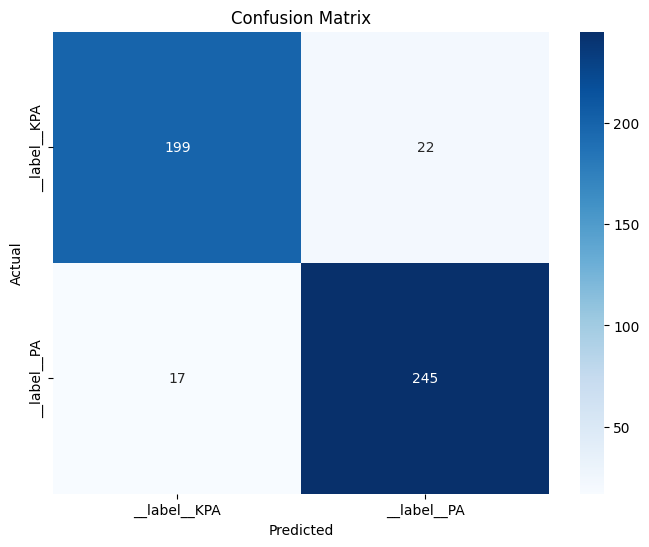

In [16]:
predicts = test(test_loader, n_classes=2)

In [17]:
# def load_model(model_path, n_classes):
#     model = TextClassifier(n_classes)
#     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     return model

# def predict_single_text(text, model, tokenizer, max_len, device):
#     model.eval()
#     inputs = tokenizer(text, max_length=max_len, truncation=True, padding='max_length', return_tensors='pt')
#     inputs = {key: inputs[key].to(device) for key in inputs}

#     with torch.no_grad():
#         outputs = model(**inputs)

#     logits = outputs.logits
#     predicted_labels = torch.argmax(logits, dim=1)
#     return predicted_labels.item()

# # Example usage:
# text_to_predict = "huỳnh_tuấn chủ đất 210 tờ đồ 15 phản_ánh hộ dân nguyễn_văn_gương đất 261 tờ đồ 15 hộ nguyễn_văn_tài đất 279 tờ đồ 15 ấp đá biên xã thạnh_phước huyện thạnh_hoá tỉnh long_an tự lắp kênh công_cộng nội_đồng trái_phép sử_dụng gây khó_khăn hộ dân sản_xuất kinh_doanh ảnh_hưởng năng_suất vụ mùa kính mong quyền chức_trách chuyên_môn cấp tỉnh cấp huyện_đạo đôn_đốc xử_lý vi_phạm hộ dân đúng qui_định pháp_luật"
# model_path = './results/5.pth'  # Update with your actual model path
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# max_len = 512  # Adjust based on your tokenizer's maximum length

# # Load the model
# model = load_model(model_path, n_classes=2)  # Assuming 2 classes

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# # Perform prediction
# predicted_label = predict_single_text(text_to_predict, model, tokenizer, max_len, device)
# print(f"Predicted Label Index: {predicted_label}")

# Model training with __label__KPA: 0 & __label__PA: 1

In [18]:
class_names = ['KPA','PA']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
def infer(text, tokenizer, max_len=258):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(y_pred)

    print(f'Text: {text}')
    print(f'Label: {class_names[y_pred]}')

In [1]:
text_to_predict = "gửi ban giám hiệu trườg thcs thuận thành, tui thấy chương trình học lớp 6 năm nay học bsang, mà trường xếp thời khóa biểu trái buổi chỉ học 1 tiết, 1 tuần 2 ngày như vây tôi thấy rất khó khăn cho viẹc đưa rước hs, vì hầu hết cha mẹ làm công nhân phải thuê người đưa rước rất tốn kém, nên tôi rất tha thiết trường sắp xếp dồn vào 1 buổi hoặc đôn lên những buổi sáng học có 3 tiết."
infer(text_to_predict,tokenizer)

NameError: name 'infer' is not defined